# Tutorial 快速入门

https://github.com/facebookresearch/faiss/wiki/Faiss-indexes
https://github.com/facebookresearch/faiss/wiki/Getting-started

## 数据准备

faiss可以处理固定维度d的向量集合，这样的集合这里用二维数组表示。
一般来说，我们需要两个数组：  
1. data。包含被索引的所有向量元素；  
2. query。索引向量，我们需要根据索引向量的值返回xb中的最近邻元素。  

为了对比不同索引方式的差别，在下面的例子中我们统一使用完全相同的数据，即维数d为512，data包含2000个向量，每个向量符合正态分布。  

需要注意的是，faiss需要数组中的元素都是32位浮点数格式。 datatype = 'float32'。

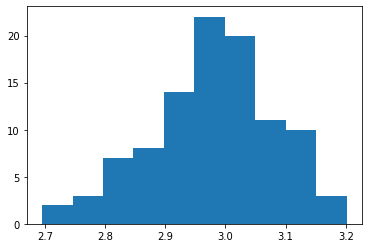

In [1]:
import numpy as np 

d = 512          #维数
n_data = 2000   
np.random.seed(0) 
data = []
mu = 3
sigma = 0.1
for i in range(n_data):
    data.append(np.random.normal(mu, sigma, d))
data = np.array(data).astype('float32')

# print(data[0])

# 查看第六个向量是不是符合正态分布
import matplotlib.pyplot as plt 

plt.hist(data[5])
plt.show()

In [2]:
query = []
n_query = 10
mu = 3
sigma = 0.1
np.random.seed(12) 
query = []
for i in range(n_query):
    query.append(np.random.normal(mu, sigma, d))
    
query = np.array(query).astype('float32')

## 精确索引IndexFlatL2

在使用faiss时，我们是围绕index对象进行的。index中包含被索引的数据库向量，在索引时可以选择不同方式的预处理来提高索引的效率，表现维不同的索引类型。在精确搜索时选择最简单的IndexFlatL2索引类型。  
IndexFlatL2类型遍历计算查询向量与被查询向量的L2精确距离，不需要训练操作（大部分index类型都需要train操作）。  
在构建index时要提供相关参数，这里是向量维数d，构建完成index之后可以通过add()和search（）进行查询。

In [3]:
import sys
import faiss

index = faiss.IndexFlatL2(d)  # 构建index
print(index.is_trained)  # False时需要train
index.add(data)  #添加数据
print(index.ntotal)  #index中向量的个数

True
2000


In [4]:
k = 10  # 返回结果个数
D, I = index.search(data[:5], k)
print(D)  # 升序返回每个查询向量的距离
print(I)  # 升序返回每个查询向量的k个相似结果

[[0.        1.2829776 1.3641686 1.3812703 1.3849722 1.3912473 1.3994429
  1.4025295 1.4037094 1.4079053]
 [0.        1.368879  1.4174371 1.4189004 1.4246064 1.430937  1.4331646
  1.4413172 1.4529448 1.4625998]
 [0.        1.157687  1.2083466 1.2494283 1.280678  1.2823849 1.2954084
  1.3043538 1.3075314 1.3217593]
 [0.        1.0911447 1.1824219 1.2296933 1.2653623 1.2776314 1.286613
  1.3176961 1.3180162 1.3240614]
 [0.        1.3546009 1.3560011 1.3611779 1.3688681 1.4176067 1.4183917
  1.4264245 1.4330984 1.4588088]]
[[   0 1032  649 1558  143 1192 1474  613  640 1597]
 [   1  265   58 1094 1563  946  933 1984 1616  209]
 [   2  639  132  588 1465  736 1739  541 1962 1228]
 [   3 1086 1848 1398 1517 1468 1397  536  742  679]
 [   4 1419   29 1440  620  389 1465   11 1598  736]]


因为查询向量是数据库向量的子集，所以每个查询向量返回的结果中排序第一的是其本身，L2距离是0.

In [5]:
k = 10
D, I = index.search(query, k)
print(D)
print(I)

[[1.2294462 1.3750875 1.4090068 1.4262743 1.4348589 1.4469216 1.4743898
  1.4857035 1.5067428 1.5173342]
 [1.3662405 1.3920488 1.422707  1.4335755 1.4338295 1.479499  1.4911768
  1.5094795 1.5127112 1.5139337]
 [1.3230866 1.3536367 1.397093  1.419579  1.4351615 1.4408715 1.4439094
  1.45291   1.4636061 1.470805 ]
 [1.0740044 1.1370447 1.1435342 1.1444734 1.1694144 1.1728494 1.1764221
  1.1861541 1.20505   1.2210077]
 [1.346811  1.351763  1.3891807 1.4012605 1.4232904 1.4240739 1.4379985
  1.4396176 1.4462258 1.4483483]
 [1.2752745 1.283745  1.3816826 1.3954791 1.398668  1.4274952 1.4317355
  1.4367782 1.4506375 1.4556841]
 [1.3081834 1.3105085 1.3736488 1.3772323 1.3877007 1.3928516 1.4037447
  1.4084623 1.4141048 1.4164046]
 [1.306488  1.420799  1.4474186 1.4499722 1.4573352 1.46053   1.4618803
  1.4672298 1.474451  1.4858212]
 [1.5473585 1.5580266 1.5886201 1.6103308 1.6163142 1.6447649 1.6470851
  1.6563122 1.6637292 1.6638479]
 [1.2707102 1.3286436 1.332122  1.3655846 1.3766267 1.3

## 倒排表快速索引IndexIVFFlat

在数据量非常大的时候，需要对数据做预处理来提高索引效率。一种方式是对数据库向量进行分割，划分为多个d维Voronoi空间，查询阶段，只需要将查询向量落入的维诺空间中的数据库向量与之比较，返回计算所得的k个最近邻结果即可，大大缩减了索引时间。  
- nlist参数控制将数据集向量分为多少个Voronoi空间
- nprobe参数控制在多少个维诺空间的范围内进行索引

In [6]:
nlist = 50  # 将数据库向量分割为多少了维诺空间
k = 10
quantizer = faiss.IndexFlatL2(d)  # 量化器
# METRIC_L2计算L2距离, 或faiss.METRIC_INNER_PRODUCT计算内积
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)

print(index.is_trained)   #倒排表索引类型需要训练
index.train(data)  # 训练数据集应该与数据库数据集同分布
print(index.is_trained)

index.add(data)
index.nprobe = 50  # 选择n个维诺空间进行索引
D, I = index.search(query, k)
print(D)
print(I)

False
True
[[1.2294462 1.3750875 1.4090068 1.4262743 1.4348589 1.4469216 1.4743898
  1.4857035 1.5067428 1.5173342]
 [1.3662405 1.3920488 1.422707  1.4335755 1.4338295 1.479499  1.4911768
  1.5094795 1.5127112 1.5139337]
 [1.3230866 1.3536367 1.397093  1.419579  1.4351615 1.4408715 1.4439094
  1.45291   1.4636061 1.470805 ]
 [1.0740044 1.1370447 1.1435342 1.1444734 1.1694144 1.1728494 1.1764221
  1.1861541 1.20505   1.2210077]
 [1.346811  1.351763  1.3891807 1.4012605 1.4232904 1.4240739 1.4379985
  1.4396176 1.4462258 1.4483483]
 [1.2752745 1.283745  1.3816826 1.3954791 1.398668  1.4274952 1.4317355
  1.4367782 1.4506375 1.4556841]
 [1.3081834 1.3105085 1.3736488 1.3772323 1.3877007 1.3928516 1.4037447
  1.4084623 1.4141048 1.4164046]
 [1.306488  1.420799  1.4474186 1.4499722 1.4573352 1.46053   1.4618803
  1.4672298 1.474451  1.4858212]
 [1.5473585 1.5580266 1.5886201 1.6103308 1.6163142 1.6447649 1.6470851
  1.6563122 1.6637292 1.6638479]
 [1.2707102 1.3286436 1.332122  1.3655846 1.

通过改变nprobe的值，发现在nprobe值较小的时候，查询可能会出错，

但时间开销很小，随着nprobe的值增加，精度逐渐增大，但时间开销也逐渐增加，

当nprobe=nlist时，等效于IndexFlatL2索引类型。  

简而言之，`倒排表索引首先将数据库向量通过聚类方法分割成若干子类，每个子类用类中心表示，当查询向量来临，选择距离最近的类中心，然后在子类中应用精确查询方法，通过增加相邻的子类个数提高索引的精确度。`

## 乘积量化索引IndexIVFPQ

在上述两种索引方式中，在index中都保存了完整的数据库向量，在数据量非常大的时候会占用太多内存，甚至超出内存限制。

在faiss中，当数据量非常大的时候，一般采用乘积量化方法保存原始向量的有损压缩形式,故查询阶段返回的结果也是近似的。

In [7]:
nlist = 50
m = 8                             # 列方向划分个数，必须能被d整除
k = 10
quantizer = faiss.IndexFlatL2(d)  
index = faiss.IndexIVFPQ(quantizer, d, nlist, m, 4)
                                    # 4 表示每个子向量被编码为 4 bits
index.train(data)
index.add(data)
index.nprobe = 50
dis, ind = index.search(data[:5], k)  # 查询自身
print(dis)
print(ind)
dis, ind = index.search(query, k)  # 真实查询
print(dis)
print(ind)

RuntimeError: Error in void faiss::ProductQuantizer::set_derived_values() at impl/ProductQuantizer.cpp:189: Error: 'd % M == 0' failed

实验发现，乘积量化后查询返回的距离值与真实值相比偏小，返回的结果只是近似值。  
查询自身时能够返回自身，但真实查询时效果较差，这里只是使用了正态分布的数据集，在真实使用时效果会更好，原因有：  
1. 正态分布的数据相对更难查询，难以聚类/降维；  
2. 自然数据相似的向量与不相似的向量差别更大，更容易查找；